<h1>Algoritmo Genético - Trabajo IA 2018</h1>
Integrantes

- Sebastian Gaete
- Elard Koch
- Israel Díaz
- Francisco González
- Humberto Campos

**notas**<br>
representación de individuo:
diccionario de python, el cual posee las siguientes claves,valores:

- **doors**: lista de puertas asociadas
- **ticks**: cantidad de ticks promedio del individuo
- **gen**: generación del individuo

una población de  individuos corresponderá a una lista de diccionarios

In [81]:
netlogo = None

In [82]:
import platform
import pyNetLogo
import random
import numpy as np
import pprint
pp = pprint.PrettyPrinter(indent=4)

netlogo_gui=False #ejecutar netlogo con interfaz grafica (True = si, False = no)
current_gen = 0 #contador de la generación actual
max_gen=30 #total de generaciones
n_doors = 5 #numero de puertas a ubicar
pop_size=20 #tamaño poblacion
n_iterations=3 #cantidad de iteraciones por individuo
n_tournament=4 #cantidad de individuos por torneo
p_cross=0.5#probabilidad de recombinacion
p_mut=0.2 #probabilidad de mutacion

plan_file="school.plan"

population = []
good_doors=[] #lista de coordenadas que pueden albergar una puerta 

- Para iniciar netlogo: **launch_netlogo()**
- Para finalizar netlogo: **kill_netlogo()**

In [83]:

def launch_netlogo():
    global netlogo
    print("Trying to start netlogo, please wait...")
    try:
        sistema=platform.system()
        if(sistema=='Windows'):
            netlogo = pyNetLogo.NetLogoLink(gui=netlogo_gui)
        elif(sistema=='Linux'):
            netlogo = pyNetLogo.NetLogoLink(gui=netlogo_gui,netlogo_home='NetLogo 6.0.4/')
        else:
            netlogo = pyNetLogo.NetLogoLink(gui=netlogo_gui)
        print("Done!")
    except Exception as e:
        print("Ocurrio un problema al levantar netlogo!")
        print(e)

def kill_netlogo():
    global netlogo
    if netlogo!=None:
        try:
            netlogo.kill_workspace()
            netlogo = None
        except Exception as e:
            print("An exception has ocurred while attempíng to kill NetLogo!")
            print(e)
    else:
        print("Please start netlogo first before kill it")

<h1>Funciones para algoritmo genético</h1>

In [84]:
#simulate recibe la lista ordenada de coordenadas de puertas, realiza la simulación correspondiente y retorna los ticks que ha demorado
#La distribución de puertas debe estar previamente validada, en caso de que las puertas no sean accesibles, la simulación podría quedar atascada en un while infinito
def simulate(doors):
    str_command = "set door-data {0}".format(str(doors).replace(',','').replace("[","[ ").replace("]"," ]")).replace("(","[").replace(")","]")
    netlogo.command(str_command)
    netlogo.command("show-plan")
    netlogo.command("generate-population")
    while(netlogo.report("count turtles")>0):
        netlogo.command("go")
    return(netlogo.report("ticks"))

def simulate_ind(individual):
    doors = list(map(lambda i:[good_doors[i][0],good_doors[i][1]],individual['doors']))
    return simulate(doors)
    
def get_good_doors(): #Obtener las coordenadas x e y de todas las puertas(posibles) que nos sirven
    x=list(map(lambda i:int(i),netlogo.report("listax")))
    y=list(map(lambda i:int(i),netlogo.report("listay")))
    return list(map(lambda i:(x[i],y[i]),range(len(x))))

def gen_zero(): #crea la generacion 0
    tmp_population=[]
    for i in range(pop_size):
        individual = {
            'doors':[],
            'gen':0,
            'ticks':0
        }
        tmp_population.append(individual)
        for j in range(n_doors):
            random_door_index = random.randint(0,len(good_doors) - 1)
            individual['doors'].append(random_door_index)
    return tmp_population
        

def evaluate_population(pop):
    for individual in pop:
        if(individual["ticks"]==0):
            simulations_ticks=[]
            for i in range(n_iterations):
                ticks = simulate_ind(individual)
                simulations_ticks.append(ticks)
            individual['ticks'] = np.mean(simulations_ticks)
    
    
# def do_tournament(pop,n_players):
#     result = []
#     tmp_pop = pop.copy()
#     if(n_players > len(pop)):
#         n_players=len(pop)
#     while len(tmp_pop) >= n_players:
#         players_selection = []
#         while(len(players_selection)<n_players):
#             selection = np.random.choice(tmp_pop)
#             if(selection not in players_selection):
#                 players_selection.append(selection)
#         players_doors=list(map(lambda p:p['doors'],players_selection))
#         winner = players_selection[np.argmin([ i['ticks'] for i in players_selection])]
#         tmp_pop=list(filter(lambda p:p['doors'] not in players_doors,tmp_pop))
#         result.append(winner)
#     if(len(tmp_pop)>0):
#         winner = tmp_pop[np.argmin([ i['ticks'] for i in tmp_pop])]
#         result.append(winner)
#         tmp_pop=list(filter(lambda p:p['doors'] not in players_doors,tmp_pop))
#     return result
# def do_tournament(pop,n_players):
#     result = []
#     tmp_pop = pop.copy()
#     if(n_players > len(pop)):
#         n_players=len(pop)
#     for i in range(len(tmp_pop)):
#         players_selection = []
#         for j in range (n_players):
#             selection = np.random.choice(tmp_pop)
#             players_selection.append(selection)
#         winner = players_selection[np.argmin([ i['ticks'] for i in players_selection])]
#         result.append(winner)    
#     return result
def do_tournament(pop,n_players):
    result = []
    dimension=len(pop)//10
    tmp_pop = pop.copy()
    tmp_pop=sorted(tmp_pop, key=lambda x:x['ticks'])
    if(n_players > len(pop)):
        n_players=len(pop)
    for i in range(dimension):
        result.append(tmp_pop[i])
    for i in range((len(tmp_pop)-dimension)):
        players_selection = []
        for j in range (n_players):
            selection = np.random.choice(tmp_pop)
            players_selection.append(selection)
        winner = players_selection[np.argmin([ i['ticks'] for i in players_selection])]
        result.append(winner)    
    return result

# def do_crossover(pop,gen_number=0):
#     new_pop=[]
#     punto_corte = random.randint(1,n_doors - 1)
#     for i in range(len(pop)//2):
#         parent1=pop[i]['doors']
#         parent2=pop[len(pop)//2 + i]['doors']
#         new_individual = {
#             'doors':parent1[:punto_corte] + parent2[punto_corte:],
#             'gen':gen_number,
#             'ticks':0
#         }
#         new_pop.append(new_individual)
#     return new_pop
def do_crossover(pop,gen_number):
    new_pop = pop.copy()
    cross_pop=[]
    indexes=[]
    for individual in range (len(new_pop)):
        if (np.random.random() <= p_cross):
#             temp=new_pop.pop(individual)
            indexes.append(individual)
            cross_pop.append(new_pop[individual])
    if(len(cross_pop)%2==1):
        r=random.randint(0,len(cross_pop)-1)
        cross_pop.pop(r)
        indexes.pop(r)

    for i in range (int(len(cross_pop)/2)):
        punto_corte = random.randint(1,n_doors - 1)
        parent1=cross_pop[i]['doors']
        parent2=cross_pop[int(len(cross_pop)/2 + i)]['doors']
        new_individual_1 = {
            'doors':parent1[:punto_corte] + parent2[punto_corte:],
            'gen':gen_number,
            'ticks':0
        }
        new_individual_2={
            'doors':parent1[punto_corte:]+parent2[:punto_corte],
            'gen':gen_number,
            'ticks':0
        }
        cross_pop[i]=new_individual_1
        cross_pop[int(len(cross_pop)/2) + i]=new_individual_2
        for i in range(len(indexes)):
            new_pop[indexes[i]]=cross_pop[i]
        
    result=new_pop
    return result

def do_mutate(pop,prob):
    new_pop = pop.copy()
    for individual in new_pop:
        if np.random.random() <= prob:
            random_index = random.randint(0,n_doors - 1)
            new_door = np.random.randint(len(good_doors))
            while(new_door == individual['doors'][random_index]):
                new_door = np.random.randint( len(good_doors))
            individual['doors'][random_index] = new_door
            individual['ticks']=0
    return new_pop

def get_best_from_pop(pop):
#     best_index = np.argmin(list(map(lambda p:p['ticks'],pop)))
#     best = pop[best_index]
    best = pop[np.argmin([ i['ticks'] for i in pop])]
    return best

def get_mean(pop):
    media = np.mean(np.array(list(map(lambda p:p['ticks'],pop))))
    return media

def GetNG(pop3,Num_new_gen):
    new_gen=[]
    old_gen=[]
    for i in range(len(pop3)):
        if(pop3[i]['gen']==Num_new_gen):
            new_gen.append(pop3[i])
        else:
            old_gen.append(pop3[i])
    return new_gen,old_gen

def Reinsert(pop0,npop):
    for i in range(len(npop)):
        pop0.append(npop[i])
    return pop0



In [85]:
kill_netlogo()
launch_netlogo()

Please start netlogo first before kill it
Trying to start netlogo, please wait...
Done!


In [86]:
netlogo.load_model(r'escape4_v6.nlogo')

<h1>Bucle evolutivo</h1>

In [87]:
import time


netlogo.command('set plan-data "{0}"'.format(plan_file))
netlogo.command("load-plan-file")
good_doors = get_good_doors() #guardar las puertas posibles en good_doors
good_doors.sort()
start_time = time.time()
print("Generating population...")
pop2 = gen_zero()
print("Done!")
#print("|{0:_^5}|".format("Gen"))

best_of = []
all_mean=[]
while current_gen <= max_gen:
#     iter_time = time.time()
    print("{0:#^10}".format("Gen " + str(current_gen)))
#     print("Population size: {0}".format(len(pop2)))
#     print("Evaluating...",end="")
    
    evaluate_population(list(filter(lambda p:p['ticks'] ==0,pop2)))
    population.append(pop2)
#     best_of_this_gen = get_best_from_pop(pop2)#encontrar el mejor (para realizar el grafico)
#     best_of.append( (current_gen,best_of_this_gen))#guardarlo en una lista junto con la genereacion (para el grafico)
#     gen_mean=get_mean(pop2)
#     all_mean.append((current_gen,gen_mean))
    
#     print("Done!")
    if(current_gen < max_gen):
#         print("Tournament...",end="")
        winners = do_tournament(pop2,n_tournament)
#         print("Done!")
#         print("Crossing...",end="")
        cross = do_crossover(winners, current_gen + 1)
    
        NG,LG=GetNG(cross,current_gen + 1)
#         print("Done!")
#         print("Mutation phase...",end="")

        result = do_mutate(NG,p_mut)
#         print("Done!")
        pop2=Reinsert(LG,result)

    
    print("Gen analysis finished")
#     elapsed_time = time.time() - iter_time
#     print("Elapsed time: {0}".format(elapsed_time))
    current_gen = current_gen + 1
# print(pop2)
elapsed_time = time.time() - start_time
print("Total elapsed time: {0}".format(elapsed_time))



Generating population...
Done!
##Gen 0###
Gen analysis finished
##Gen 1###
Gen analysis finished
##Gen 2###
Gen analysis finished
##Gen 3###
Gen analysis finished
##Gen 4###
Gen analysis finished
##Gen 5###
Gen analysis finished
##Gen 6###
Gen analysis finished
##Gen 7###
Gen analysis finished
##Gen 8###
Gen analysis finished
##Gen 9###
Gen analysis finished
##Gen 10##
Gen analysis finished
##Gen 11##
Gen analysis finished
##Gen 12##
Gen analysis finished
##Gen 13##
Gen analysis finished
##Gen 14##
Gen analysis finished
##Gen 15##
Gen analysis finished
##Gen 16##
Gen analysis finished
##Gen 17##
Gen analysis finished
##Gen 18##
Gen analysis finished
##Gen 19##
Gen analysis finished
##Gen 20##
Gen analysis finished
##Gen 21##
Gen analysis finished
##Gen 22##
Gen analysis finished
##Gen 23##
Gen analysis finished
##Gen 24##
Gen analysis finished
##Gen 25##
Gen analysis finished
##Gen 26##
Gen analysis finished
##Gen 27##
Gen analysis finished
##Gen 28##
Gen analysis finished
##Gen 29##
G

In [73]:
population

[[{'doors': [216, 123, 107, 80, 211], 'gen': 0, 'ticks': 158.0},
  {'doors': [251, 298, 225, 257, 247], 'gen': 0, 'ticks': 233.0},
  {'doors': [173, 300, 301, 67, 36], 'gen': 0, 'ticks': 125.0},
  {'doors': [7, 146, 192, 92, 43], 'gen': 0, 'ticks': 197.0},
  {'doors': [200, 244, 305, 240, 220], 'gen': 0, 'ticks': 138.0},
  {'doors': [169, 297, 40, 224, 238], 'gen': 0, 'ticks': 128.0},
  {'doors': [113, 98, 348, 113, 317], 'gen': 0, 'ticks': 125.0},
  {'doors': [286, 0, 6, 170, 111], 'gen': 0, 'ticks': 137.0},
  {'doors': [63, 257, 92, 229, 46], 'gen': 0, 'ticks': 218.0},
  {'doors': [320, 277, 37, 116, 61], 'gen': 0, 'ticks': 132.0},
  {'doors': [112, 328, 309, 269, 236], 'gen': 0, 'ticks': 175.0},
  {'doors': [275, 274, 95, 152, 280], 'gen': 0, 'ticks': 163.0},
  {'doors': [32, 337, 95, 284, 69], 'gen': 0, 'ticks': 127.0},
  {'doors': [255, 178, 303, 95, 65], 'gen': 0, 'ticks': 130.0},
  {'doors': [53, 94, 172, 253, 1], 'gen': 0, 'ticks': 119.0},
  {'doors': [115, 151, 83, 97, 272], '

In [88]:
best_of=[]
all_mean=[]
for i in range(len(population)):
    best_of_this_gen = get_best_from_pop(population[i])#encontrar el mejor (para realizar el grafico)
    best_of.append( (i,best_of_this_gen))#guardarlo en una lista junto con la genereacion (para el grafico)
    gen_mean=get_mean(population[i])
    all_mean.append((i,gen_mean))
    

Best door combination:
[(39, 37), (56, 17), (68, 22), (104, 49), (71, 62)]
ticks:64.33333333333333
Generation:4


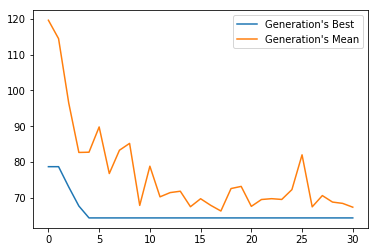

In [89]:
import matplotlib.pyplot as plt

x_points=list(map(lambda x:x[0],best_of))
y_points=list(map(lambda x:x[1]['ticks'],best_of))
z_points=list(map(lambda x:x[1],all_mean))

best_of_all_time_index = np.argmin(y_points)
best_of_all_time = best_of[best_of_all_time_index][1]
best_doors = list(map(lambda i:good_doors[i] ,best_of_all_time['doors']))

print("Best door combination:\n{0}\nticks:{1}\nGeneration:{2}".format(best_doors,best_of_all_time['ticks'],best_of_all_time['gen']))

plt.plot(x_points,y_points,z_points)
plt.legend(("Generation's Best","Generation's Mean"))
plt.show()

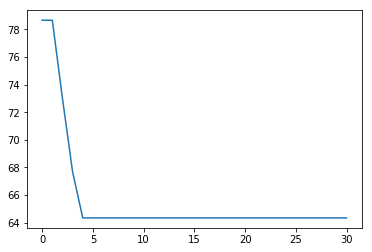

In [90]:
import matplotlib.pyplot as plt

x_points=list(map(lambda x:x[0],best_of))
y_points=list(map(lambda x:x[1]['ticks'],best_of))

plt.plot(x_points,y_points)
plt.show()

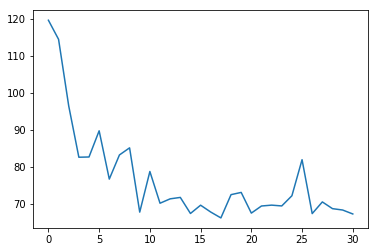

In [91]:
x_points=list(map(lambda x:x[0],all_mean))
y_points=list(map(lambda x:x[1],all_mean))

# print("Best door combination:\n{0}\nticks:{1}".format(best_doors,best_of_all_time['ticks']))

plt.plot(x_points,y_points)
plt.show()

In [20]:
len(population)

11

In [19]:
best_of

[(0, {'doors': [330, 186, 306, 209, 321], 'gen': 0, 'ticks': 102.0}),
 (1, {'doors': [214, 330, 186, 306, 209], 'gen': 1, 'ticks': 79.5}),
 (2, {'doors': [209, 160, 4, 206, 268], 'gen': 2, 'ticks': 82.0}),
 (3, {'doors': [209, 160, 4, 206, 268], 'gen': 3, 'ticks': 84.5})]

In [ ]:
all_mean

In [23]:
for x  in population:
    print("gen")
    for i in x:
        print(i)


gen
{'doors': [305, 11, 73, 315, 172], 'gen': 0, 'ticks': 96.66666666666667}
{'doors': [165, 74, 317, 149, 295], 'gen': 0, 'ticks': 109.66666666666667}
{'doors': [64, 52, 102, 49, 40], 'gen': 0, 'ticks': 188.66666666666666}
{'doors': [176, 262, 176, 120, 181], 'gen': 0, 'ticks': 180.66666666666666}
{'doors': [151, 349, 266, 75, 299], 'gen': 0, 'ticks': 98.66666666666667}
{'doors': [201, 226, 285, 232, 270], 'gen': 0, 'ticks': 112.33333333333333}
{'doors': [57, 207, 346, 4, 340], 'gen': 0, 'ticks': 101.33333333333333}
{'doors': [190, 320, 106, 256, 67], 'gen': 0, 'ticks': 101.66666666666667}
{'doors': [240, 186, 225, 172, 9], 'gen': 0, 'ticks': 91.33333333333333}
{'doors': [51, 37, 314, 115, 335], 'gen': 0, 'ticks': 90.0}
{'doors': [211, 163, 172, 180, 278], 'gen': 0, 'ticks': 165.0}
{'doors': [206, 347, 226, 154, 179], 'gen': 0, 'ticks': 100.33333333333333}
{'doors': [12, 63, 206, 172, 23], 'gen': 0, 'ticks': 177.33333333333334}
{'doors': [82, 255, 44, 91, 335], 'gen': 0, 'ticks': 136.

In [48]:
population[25]

[{'doors': [126, 307, 229, 126, 187], 'gen': 25, 'ticks': 90.0},
 {'doors': [191, 307, 229, 126, 175], 'gen': 24, 'ticks': 72.0},
 {'doors': [307, 229, 31, 191, 113], 'gen': 23, 'ticks': 94.0},
 {'doors': [229, 126, 187, 191, 19], 'gen': 25, 'ticks': 98.5},
 {'doors': [193, 191, 307, 229, 126], 'gen': 23, 'ticks': 104.0},
 {'doors': [48, 187, 229, 307, 229], 'gen': 25, 'ticks': 89.0},
 {'doors': [191, 340, 191, 277, 229], 'gen': 25, 'ticks': 84.0},
 {'doors': [126, 340, 191, 196, 229], 'gen': 20, 'ticks': 70.5},
 {'doors': [307, 229, 191, 307, 229], 'gen': 25, 'ticks': 138.0},
 {'doors': [113, 229, 126, 340, 126], 'gen': 25, 'ticks': 134.5},
 {'doors': [229, 126, 187, 229, 140], 'gen': 25, 'ticks': 166.5},
 {'doors': [219, 126, 187, 191, 113], 'gen': 23, 'ticks': 69.5},
 {'doors': [126, 340, 187, 191, 113], 'gen': 25, 'ticks': 89.5},
 {'doors': [126, 187, 229, 191, 113], 'gen': 25, 'ticks': 75.0},
 {'doors': [126, 340, 126, 340, 191], 'gen': 25, 'ticks': 146.5},
 {'doors': [126, 187, 1

In [19]:
kill_netlogo()

128.8